# Text classification

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc
import pandas as pd
import numpy as np
import re

## Get and load data

In [34]:
# Load data
url = 'text.csv'
data = pd.read_csv(url)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
# Spit data to train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.target, test_size=0.1, random_state=1)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6851,), (762,), (6851,), (762,))

In [40]:
# Get sample docs from train dataset
sample_docs = list(X_train.iloc[0:10].values)

for text, is_disaster in zip(sample_docs, y_train[0:10]):
  print(f'\n> {text}\n> is_disaster = {is_disaster}')


> Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.
> is_disaster = 1

> Experts leave lab as Malaysia confirms debris is from #MH370 http://t.co/Ba4pUSvJLN
> is_disaster = 1

> Please stand up for bees against profit-hungry chemical companies. Keep the ban &amp; #Savebees 
Sign the petition now:
https://t.co/4zsXjGV7iT
> is_disaster = 0

> #hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/FLqxd3q5pY #prebreak #best
> is_disaster = 1

> Do you feel deluged by low self-image? Take the quiz: http://t.co/QN4ZYISsPO http://t.co/3VWp7wD56W
> is_disaster = 0

> Spent too many hours sinking into the wonderfully created worlds of Mafia and Mafia II in my life. Excited for another installment.
> is_disaster = 0

> 95-03 BMW 528 530 540 740 Emergency Warning Hazard Switch Button OEM 20177-707D http://t.co/kVNahTHUWZ http://t.co/Y8xkNpqMnJ
> is_disaster = 0

> //im gonna b

## Text data preparation

In [170]:
# Remove hyperlinks
sample_docs_url_rm = [re.sub(r"http\S+", "", x) for x in sample_docs]
sample_docs_url_rm

['Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.',
 'Experts leave lab as Malaysia confirms debris is from #MH370 ',
 'Please stand up for bees against profit-hungry chemical companies. Keep the ban &amp; #Savebees \nSign the petition now:\n',
 '#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980  #prebreak #best',
 'Do you feel deluged by low self-image? Take the quiz:  ',
 'Spent too many hours sinking into the wonderfully created worlds of Mafia and Mafia II in my life. Excited for another installment.',
 '95-03 BMW 528 530 540 740 Emergency Warning Hazard Switch Button OEM 20177-707D  ',
 '//im gonna beat armageddon as Hsu Hao ????\njust got a flawless on my first try',
 'RT RoadID: Thanks to Alex for his story &amp; to all first responders for being there when we need you. \x89Û_ ',
 'Listening to Blowers and Tuffers on the Aussie batting collapse at Trent Bridge remin

In [172]:
import html
sample_docs_html_rm = [html.unescape(x) for x in sample_docs_url_rm]
sample_docs_html_rm

['Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.',
 'Experts leave lab as Malaysia confirms debris is from #MH370 ',
 'Please stand up for bees against profit-hungry chemical companies. Keep the ban & #Savebees \nSign the petition now:\n',
 '#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980  #prebreak #best',
 'Do you feel deluged by low self-image? Take the quiz:  ',
 'Spent too many hours sinking into the wonderfully created worlds of Mafia and Mafia II in my life. Excited for another installment.',
 '95-03 BMW 528 530 540 740 Emergency Warning Hazard Switch Button OEM 20177-707D  ',
 '//im gonna beat armageddon as Hsu Hao ????\njust got a flawless on my first try',
 'RT RoadID: Thanks to Alex for his story & to all first responders for being there when we need you. \x89Û_ ',
 'Listening to Blowers and Tuffers on the Aussie batting collapse at Trent Bridge reminds me wh

In [47]:
# Remove @like words , like @bbctms
sample_docs_ = [re.sub('(?:\s)@[^, ]*', '', x) for x in sample_docs_html_rm]
# Remove \n
sample_docs_ = [re.sub('\n', '', x) for x in sample_docs_]
# Remove whitespaces
sample_docs_ = [ re.sub(r'\s+', ' ', x).strip() for x in sample_docs_]
sample_docs_

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3_/b3bf9f593vj02_bzbl0q9s740000gn/T/ipykernel_11698/2770645545.py:2: SyntaxWarning: invalid escape sequence '\s'
  sample_docs_ = [re.sub('(?:\s)@[^, ]*', '', x) for x in sample_docs_html_rm]


['Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.',
 'Experts leave lab as Malaysia confirms debris is from #MH370',
 'Please stand up for bees against profit-hungry chemical companies. Keep the ban & #Savebees Sign the petition now:',
 '#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 #prebreak #best',
 'Do you feel deluged by low self-image? Take the quiz:',
 'Spent too many hours sinking into the wonderfully created worlds of Mafia and Mafia II in my life. Excited for another installment.',
 '95-03 BMW 528 530 540 740 Emergency Warning Hazard Switch Button OEM 20177-707D',
 '//im gonna beat armageddon as Hsu Hao ????just got a flawless on my first try',
 'RT RoadID: Thanks to Alex for his story & to all first responders for being there when we need you. \x89Û_',
 'Listening to Blowers and Tuffers on the Aussie batting collapse at Trent Bridge reminds me why I love Wonde

##  Text/Data normalization & Tokenization

In [51]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import spacy

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Download spaCy model
spacy.cli.download("en_core_web_sm")

ModuleNotFoundError: No module named 'spacy'

In [53]:
def normalize_nltk_stem(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # Stemming
    porter_stemmer = PorterStemmer()
    stemmed_tokens = [porter_stemmer.stem(word) for word in filtered_tokens]
    return stemmed_tokens

def normalize_spacy_lemma(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]

    return filtered_tokens

for doc in sample_docs_[0:2]:
  print(f'''Doc: {doc}
  nltk+stem: {normalize_nltk_stem(doc)}
  spacy+lemm:  {normalize_spacy_lemma(doc)}''')

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/michalkoperski/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


### Tokenization

In [56]:
text = # <XXXXX>

SyntaxError: invalid syntax (3162596859.py, line 1)

In [58]:
normalize_nltk_stem(text)[0:10]

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/michalkoperski/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [60]:
normalize_spacy_lemma(text)[0:10]

NameError: name 'spacy' is not defined

## BOW and DTM

**BOW, Bag-of-words** - A collection of a distinct set of tokens from all the texts in a sample dataset. BOW does not capture the position or sequence of words present in the text.

**DTM,  Document Term Matrix** - A matrix where each row belongs to a document (or text file), and each column represents a token (or term). The number of rows is equal to the number of documents (or text files) in a sample text dataset. The number of columns is equal to the number of tokens from the BOW built using all the documents in the sample dataset. The cells typically contain the counts of the number of times a token is present in each document.

In [63]:
bow_processed = {y for x in [" ".join(normalize_spacy_lemma(z)) for z in sample_docs_] for y in x.split() if len(y)>0}
print(len(bow_processed), bow_processed)

NameError: name 'spacy' is not defined

In [65]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'wordcloud'

In [67]:
# Create a WordCloud object for disasters
disaster_text = " ".join( [" ".join(normalize_nltk_stem(z)) for z in data.query("target == 1").text])

disaster_wordcloud = WordCloud(width=800,  height=400,
                               scale=3, background_color='black',
                               stopwords = ['new', 'amp', 'news', 'via', 'Û', 'u']).generate("".join(disaster_text), )

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis labels
plt.show()

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/michalkoperski/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [69]:
# Create a WordCloud object for non-disasters
non_disaster_text = " ".join( [" ".join(normalize_nltk_stem(z)) for z in data.query("target == 0").text])
non_disaster_wordcloud = WordCloud(width=800,
                                   height=400,
                                   background_color='black',
                                   stopwords = ['new', 'amp', 'news', 'via', 'Û', 'u']).generate("".join(non_disaster_text))


# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(non_disaster_wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis labels
plt.show()

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/michalkoperski/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


### Wordcloud

In [73]:
wordcloud = # <XXXXX>
# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(# <XXXXX>
    , interpolation='bilinear')
plt.axis('off')  # Turn off the axis labels
plt.show()

SyntaxError: invalid syntax (3446977902.py, line 1)

In [75]:
cleaned_text = # <XXXXX>

wordcloud = # <XXXXX>

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(# <XXXXX>
           , interpolation='bilinear')
plt.axis('off')  # Turn off the axis labels
plt.show()

SyntaxError: invalid syntax (23598800.py, line 1)

### **CountVectorizer**

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
import re
# Define instance of CountVectorizer class
count_vect = CountVectorizer(max_features=200,
                             lowercase=True,
                             analyzer='word', #You can also try 'char'
                             stop_words= 'english',
                             ngram_range=(1,3),
                             dtype=np.float32)

sample_docs_
# Fit vectroriser on first train tweets
count_vect_sample_docs_ = count_vect.fit_transform(sample_docs_)

# Decode sprase matrix
count_vect_sample_docs_d = pd.DataFrame\
    .sparse\
    .from_spmatrix(count_vect_sample_docs_,
                   columns = count_vect.get_feature_names_out())

count_vect_sample_docs_d

,03,03 bmw,03 bmw 528,130,130 specially,130 specially modified,1980,1980 prebreak,1980 prebreak best,20177,...,warning hazard,warning hazard switch,wonderful,wonderful stuff,wonderful stuff engvaus,wonderfully,wonderfully created,wonderfully created worlds,worlds,worlds mafia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,0,0,0,0,0,0,1.0,...,1.0,1.0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,1.0,1.0,0,0,0,0,0


### ***TF-IDF (Term Frequency-Inverse Document Frequency)***

In [81]:
# Define instance of TfidfVectorizer class
tfidf_vect = TfidfVectorizer(max_features=200,
                             lowercase=True,
                             analyzer='word', #You can also try 'char'
                             stop_words= 'english',
                             ngram_range=(1,3),
                             dtype=np.float32)

# Fit vectroriser on first train tweets
tfidf_vect_sample_docs_ = tfidf_vect.fit_transform(sample_docs_)

# What's inside?
tfidf_vect_sample_docs_

<10x200 sparse matrix of type '<class 'numpy.float32'>'
	with 201 stored elements in Compressed Sparse Row format>

In [83]:
# Lets decode sprase matrix
tfidf_vect_sample_docs_d = pd.DataFrame.sparse\
    .from_spmatrix(tfidf_vect_sample_docs_,
                   columns = tfidf_vect.get_feature_names_out())

# Print decoded dataframe
print(tfidf_vect_sample_docs_d.shape)
tfidf_vect_sample_docs_d

(10, 200)


,03,03 bmw,03 bmw 528,130,130 specially,130 specially modified,1980,1980 prebreak,1980 prebreak best,20177,...,warning hazard,warning hazard switch,wonderful,wonderful stuff,wonderful stuff engvaus,wonderfully,wonderfully created,wonderfully created worlds,worlds,worlds mafia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0.19245,0.19245,0.19245,0.19245,0.19245,0.19245,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.196116,0.196116,0.196116,0.196116,0.196116
6,0.189925,0.189925,0.189925,0,0,0,0,0,0,0.189925,...,0.189925,0.189925,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0.176777,0.176777,0.176777,0,0,0,0,0


## Classification model with standard ML model (Logistic regression) on TFIDF

In [86]:
X_train_ = X_train\
    .apply(lambda x: re.sub(r"http\S+", "", x))\
    .apply(lambda x: html.unescape(x))\
    .apply(lambda x: re.sub('(?:\s)@[^, ]*', '', x))

X_test_ = X_test\
    .apply(lambda x: re.sub(r"http\S+", "", x))\
    .apply(lambda x: html.unescape(x))\
    .apply(lambda x: re.sub('(?:\s)@[^, ]*', '', x))

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3_/b3bf9f593vj02_bzbl0q9s740000gn/T/ipykernel_11698/4238067011.py:4: SyntaxWarning: invalid escape sequence '\s'
  .apply(lambda x: re.sub('(?:\s)@[^, ]*', '', x))
/var/folders/3_/b3bf9f593vj02_bzbl0q9s740000gn/T/ipykernel_11698/4238067011.py:9: SyntaxWarning: invalid escape sequence '\s'
  .apply(lambda x: re.sub('(?:\s)@[^, ]*', '', x))


In [88]:
# Define instance of TfidfVectorizer class
tfidf_vect = TfidfVectorizer(max_features=200,
                             lowercase=True,
                             analyzer='word', #You can also try 'char'
                             stop_words= 'english',
                             ngram_range=(1,3),
                             dtype=np.float32)

In [90]:
# Fit vectroriser on train dataset and transform train and test datasets
X_train_vect = tfidf_vect.fit_transform(X_train)
X_test_vect = tfidf_vect.transform(X_test)

In [92]:
model = LogisticRegression(random_state = 1)
model.fit(X_train_vect, y_train)

LogisticRegression(random_state=1)

In [94]:
 model.predict_proba(X_test_vect), model.predict(X_test_vect)

(array([[0.46569461, 0.53430539],
        [0.7770362 , 0.2229638 ],
        [0.74861261, 0.25138739],
        ...,
        [0.75610924, 0.24389076],
        [0.65601171, 0.34398829],
        [0.05325179, 0.94674821]]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

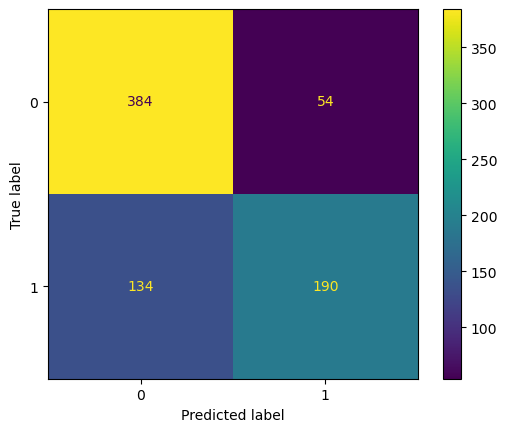

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test_vect, y_test)
plt.show()

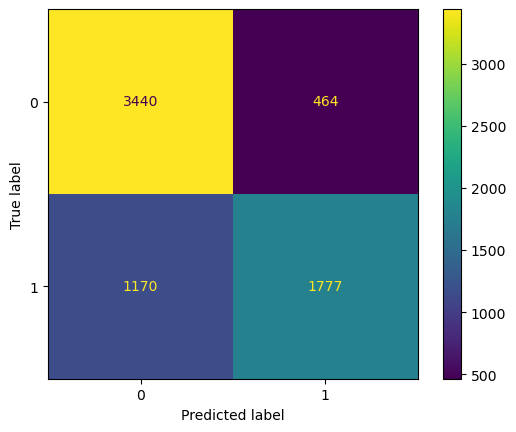

In [98]:
ConfusionMatrixDisplay.from_estimator(model, X_train_vect, y_train)
plt.show()

In [100]:
print(classification_report(y_test, model.predict(X_test_vect)))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       438
           1       0.78      0.59      0.67       324

    accuracy                           0.75       762
   macro avg       0.76      0.73      0.74       762
weighted avg       0.76      0.75      0.75       762



**ROC (Receiver Operating Characteristic)**

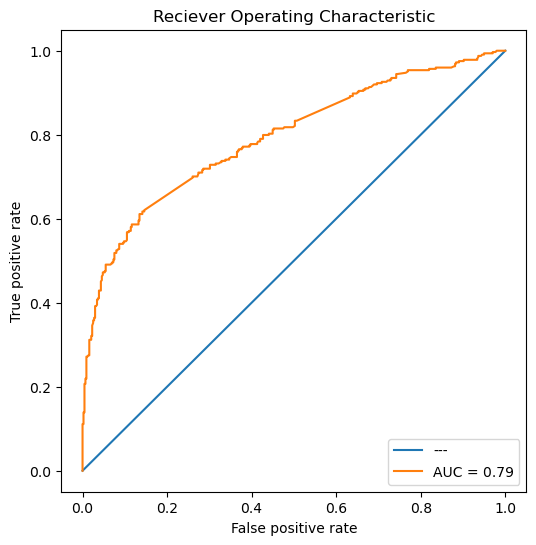

In [103]:
# Calculate ROC curve characteristics
frp, trp, thres = roc_curve(y_test,model.predict_proba(X_test_vect)[:,1])

# Calculate AUC
auc_val = auc(frp,trp)

# Plot results
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],label = f'---')
plt.plot(frp,trp, label= f'AUC = {auc_val:.2f}')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciever Operating Characteristic')
plt.show()

# Text classification with simple TensorFlow and CNN

In [106]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D

ModuleNotFoundError: No module named 'tensorflow'

## Tokenizer

### Tokenizer example

In [110]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=100)

# Fit it on some texts
texts = ['this is a sample text', 'another example']
tokenizer.fit_on_texts(texts)

# Print the word index
print(tokenizer.word_index)

# Encode a text
encoded_text = tokenizer.texts_to_sequences(['this is a new text'])
print(encoded_text)

ModuleNotFoundError: No module named 'tensorflow'

### pad_sequences example

In [114]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create a list of sequences
sequences = [
    [1, 2, 3],
    [4, 5],
    [6, 7, 8, 9]
]

# Pad the sequences
padded_sequences = pad_sequences(sequences)

print(padded_sequences)

ModuleNotFoundError: No module named 'tensorflow'

## Preprocess train data

In [117]:
N = 1000

tokenizer = Tokenizer(num_words=N,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True)

tokenizer.fit_on_texts(X_train_)
word_index = tokenizer.word_index

maxlen = 100

X_train_mat = tokenizer.texts_to_sequences(X_train)
X_train_mat = pad_sequences(X_train_mat, maxlen=maxlen)
X_train_mat.shape

<>:4: SyntaxWarning: invalid escape sequence '\]'
<>:4: SyntaxWarning: invalid escape sequence '\]'
/var/folders/3_/b3bf9f593vj02_bzbl0q9s740000gn/T/ipykernel_11698/3484627605.py:4: SyntaxWarning: invalid escape sequence '\]'
  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
/var/folders/3_/b3bf9f593vj02_bzbl0q9s740000gn/T/ipykernel_11698/3484627605.py:4: SyntaxWarning: invalid escape sequence '\]'
  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',


NameError: name 'Tokenizer' is not defined

In [119]:
X_train_.iloc[0]

'Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.'

In [121]:
X_train_mat[0]

NameError: name 'X_train_mat' is not defined

In [123]:
word_index['having']

NameError: name 'word_index' is not defined

In [125]:
X_train_mat

NameError: name 'X_train_mat' is not defined

In [127]:
X_test_mat = tokenizer.texts_to_sequences(X_test)
X_test_mat = pad_sequences(X_test_mat, maxlen=maxlen)
X_test_mat.shape

NameError: name 'tokenizer' is not defined

## Create neural network - sequential API

In [130]:
# Define the model
model = Sequential()

model.add(Input(shape = (maxlen,)))

# Add an embedding layer
model.add(Embedding(input_dim = N,
                    output_dim = 8,
                    input_length=maxlen))

# Add a Conv1D layer
model.add(Conv1D(filters = 128,
                 kernel_size = 5,
                 activation='relu'))

# Add a GlobalMaxPooling1D layer
model.add(GlobalMaxPooling1D())

# Add a Dense layer
model.add(Dense(units = 1,
                activation='relu'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

NameError: name 'Sequential' is not defined

In [132]:
# Print model summary
model.summary()

AttributeError: 'LogisticRegression' object has no attribute 'summary'

In [134]:
# Define fit parameters
epochs = 10
batch_size = 128

# Fit the model
history = model.fit(X_train_mat,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_split = 0.1)

NameError: name 'X_train_mat' is not defined

In [136]:
plt.plot(history.history['binary_accuracy'], label = 'binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_binary_accuracy')
plt.legend(loc = 1)

NameError: name 'history' is not defined

In [138]:
y_train_pred = model.predict(X_train_mat)

cm = confusion_matrix(y_true = y_train,  y_pred = y_train_pred)
#cm = confusion_matrix(y_true=y_train,  y_pred=1*(y_train_pred > .5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Disaster', 'Non-Disaster'])
disp.plot()
plt.show()

NameError: name 'X_train_mat' is not defined

In [140]:
y_test_pred = model.predict(X_test_mat)[:,0]

cm = confusion_matrix(y_true = y_test,  y_pred = 1*(y_test_pred > .5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Disaster', 'Non-Disaster'])
disp.plot()
plt.show()

NameError: name 'X_test_mat' is not defined

In [142]:
# Calculate ROC curve characteristics
frp, trp, thres = roc_curve(y_test,y_test_pred)

# Calculate AUC
auc_val = auc(frp,trp)

# Plot results
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],label = f'---')
plt.plot(frp,trp, label= f'AUC = {auc_val:.2f}')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciever Operating Characteristic')
plt.show()

NameError: name 'y_test_pred' is not defined

In [144]:
model.layers[0].input

AttributeError: 'LogisticRegression' object has no attribute 'layers'

In [146]:
model.layers[0].weights[0].numpy()

AttributeError: 'LogisticRegression' object has no attribute 'layers'

In [148]:
for layer in model.layers:
  print(layer)
  print('input: ', layer.input_shape)
  print('output:', layer.output_shape)

AttributeError: 'LogisticRegression' object has no attribute 'layers'

# CNN/RNN

In [151]:
# Define the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim = N,
                    output_dim = 128,
                    input_length=maxlen))

model.add(Dropout(0.2))

# Add a Conv1D layer
model.add(Conv1D(filters=64,
                 kernel_size=5,
                 activation='relu',
                 padding="valid",
                 strides = 1))

# Add a MaxPooling1D layer
model.add(MaxPooling1D(pool_size=4))

# Add a LSTM layer
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))

# Add a Dense layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

NameError: name 'Sequential' is not defined

In [153]:
# Define fit parameters
epochs = 4
batch_size = 64

# Fit the model
history = model.fit(X_train_mat,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)

NameError: name 'X_train_mat' is not defined

In [155]:
y_test_pred = model.predict(X_test_mat)[:,0]

cm = confusion_matrix(y_test, 1*(y_test_pred > .3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

NameError: name 'X_test_mat' is not defined

In [157]:
# Calculate ROC curve characteristics
frp, trp, thres = roc_curve(y_test,y_test_pred)

# Calculate AUC
auc_val = auc(frp,trp)

# Plot results
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],label = f'---')
plt.plot(frp,trp, label= f'AUC = {auc_val:.2f}')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciever Operating Characteristic')
plt.show()

NameError: name 'y_test_pred' is not defined

In [159]:
#Notebooks used:
#https://www.kaggle.com/faressayah/natural-language-processing-nlp-for-beginners
#https://www.kaggle.com/dmikar/cnn-and-lstm
#https://www.kaggle.com/ahlemloulou/cnn-for-disaster-classification

# Gradient Descent example

In [162]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

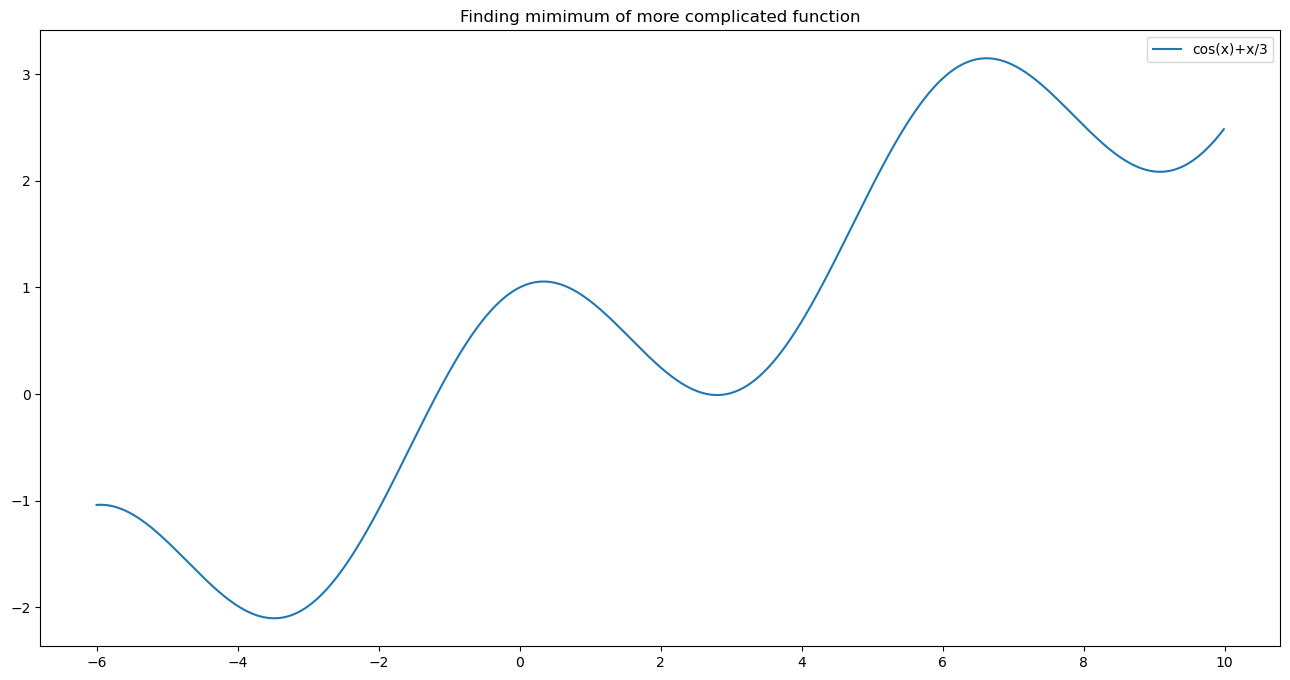

In [164]:
# Set new (more complex function)
x = np.arange(-6,10,0.01)
def foo(x): return np.cos(x)+x/3

# Plot results
plt.figure(figsize=(16,8))
plt.plot(x, foo(x), label = 'cos(x)+x/3')
plt.title('Finding mimimum of more complicated function')
plt.legend(loc=1)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Minimum at 2.80159 with value of -0.00889 achieved in 11 iterations


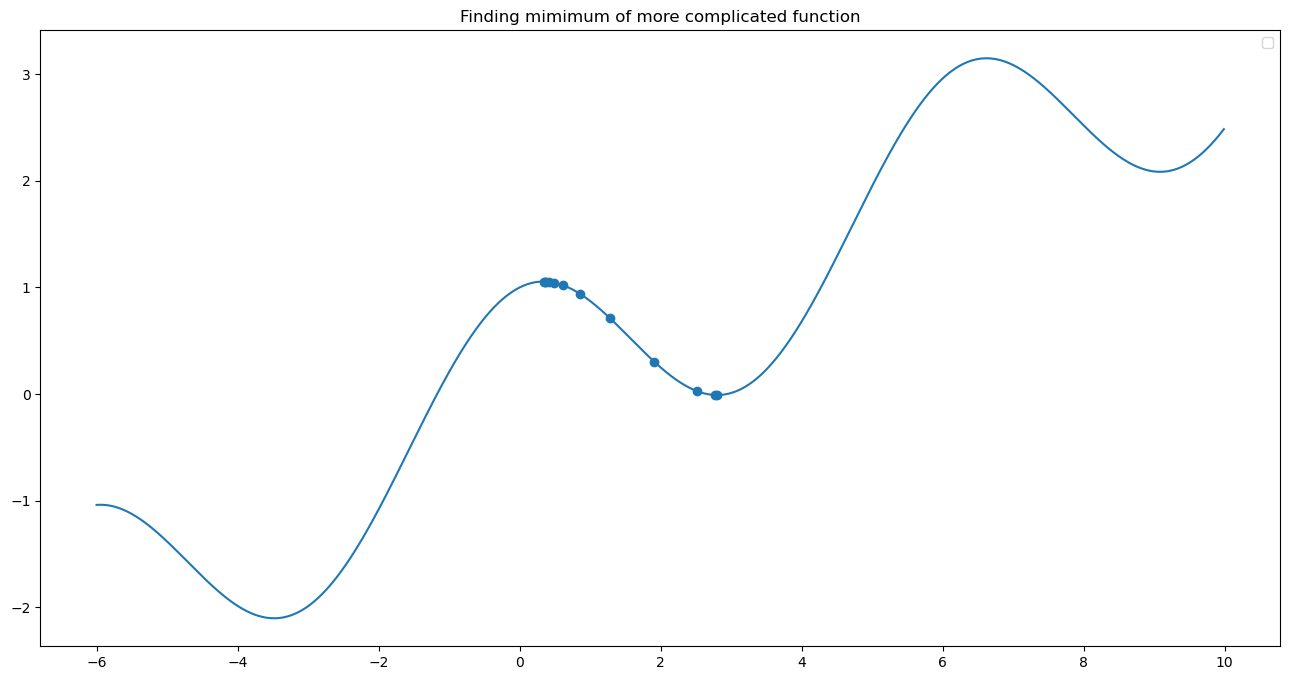

In [166]:
# Define gradient function
def gradient(x, function):
    return (function(x+0.0001)-function(x))/0.0001

step = 1
max_iters = 20
precision = 0.005

x_new = 0.35

x_track = np.zeros(max_iters)
y_track = np.zeros(max_iters)
for i in range(max_iters):
    x_old = x_new
    x_track[i] = x_old
    y_track[i] = foo(x_old)
    x_new = x_old - step * gradient(x_old, foo)
    if abs(x_new-x_old) <= precision:
        print(f'Minimum at {x_new:.5f} with value of {foo(x_new):.5f} achieved in {i} iterations')
        break
    elif i == max_iters-1:
        print('Minimum was not achieved')

plt.figure(figsize=(16,8))
plt.scatter(x_track[x_track != 0], y_track[x_track != 0])
plt.plot(x, foo(x))
plt.title('Finding mimimum of more complicated function')
plt.legend(loc=1)
plt.show()